# Unsupervised Learning

In questo notebook indagheremo l'utilizzo di alcuni algoritmi di dimensionality reduction (PCA, t-SNE) e clusterizzazione (k-means clustering, DBSCAN) applicati ad un dataset pubblico di clienti di un fornitore in ambito ristorazione, il [Wholesale Customers](https://archive.ics.uci.edu/dataset/292/wholesale+customers), di pubblico utilizzo e scaricabile dal [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/), un ampio repository pubblico di dataset.

## Import librerie e dati

Per prima cosa importiamo alcune librerie utili e il dataset direttamente dal sito.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
df = pd.read_csv("https://archive.ics.uci.edu/static/public/292/wholesale+customers.zip")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
info = df.describe().T
info["dtype"] = [df[col].dtypes for col in df.columns]
display(info)

,count,mean,std,min,25%,50%,75%,max,dtype
Channel,440.0,1.322727,0.468052,1.0,1.00,1.0,2.00,2.0,int64
Region,440.0,2.543182,0.774272,1.0,2.00,3.0,3.00,3.0,int64
Fresh,440.0,12000.297727,12647.328865,3.0,3127.75,8504.0,16933.75,112151.0,int64
Milk,440.0,5796.265909,7380.377175,55.0,1533.00,3627.0,7190.25,73498.0,int64
Grocery,440.0,7951.277273,9503.162829,3.0,2153.00,4755.5,10655.75,92780.0,int64
Frozen,440.0,3071.931818,4854.673333,25.0,742.25,1526.0,3554.25,60869.0,int64
Detergents_Paper,440.0,2881.493182,4767.854448,3.0,256.75,816.5,3922.00,40827.0,int64
Delicassen,440.0,1524.870455,2820.105937,3.0,408.25,965.5,1820.25,47943.0,int64


Notiamo che tutte le colonne sono di tipo `int64` e sono presenti 440 osservazioni. Le colonne `Region` e `Channel` rappresentano:

- `Channel`:
  - 1 = Horeca (Hotel/Restaurant/Cafè)
  - 2 = Retail
- `Region`:
  - 1 = Lisbona
  - 2 = Oporto
  - 3 = Other

Le altre colonne rappresentano la spesa annua del cliente per tipo di prodotto. Possiamo creare una nuova feature, la spesa totale annua del cliente.

In [4]:
df["total"]=df.iloc[:,2:].sum(axis=1)
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,total
0,2,3,12669,9656,7561,214,2674,1338,34112
1,2,3,7057,9810,9568,1762,3293,1776,33266
2,2,3,6353,8808,7684,2405,3516,7844,36610
3,1,3,13265,1196,4221,6404,507,1788,27381
4,2,3,22615,5410,7198,3915,1777,5185,46100


Visualizziamo ora le distribuzioni delle coppie di variabili.

/Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/seaborn/_oldcore.

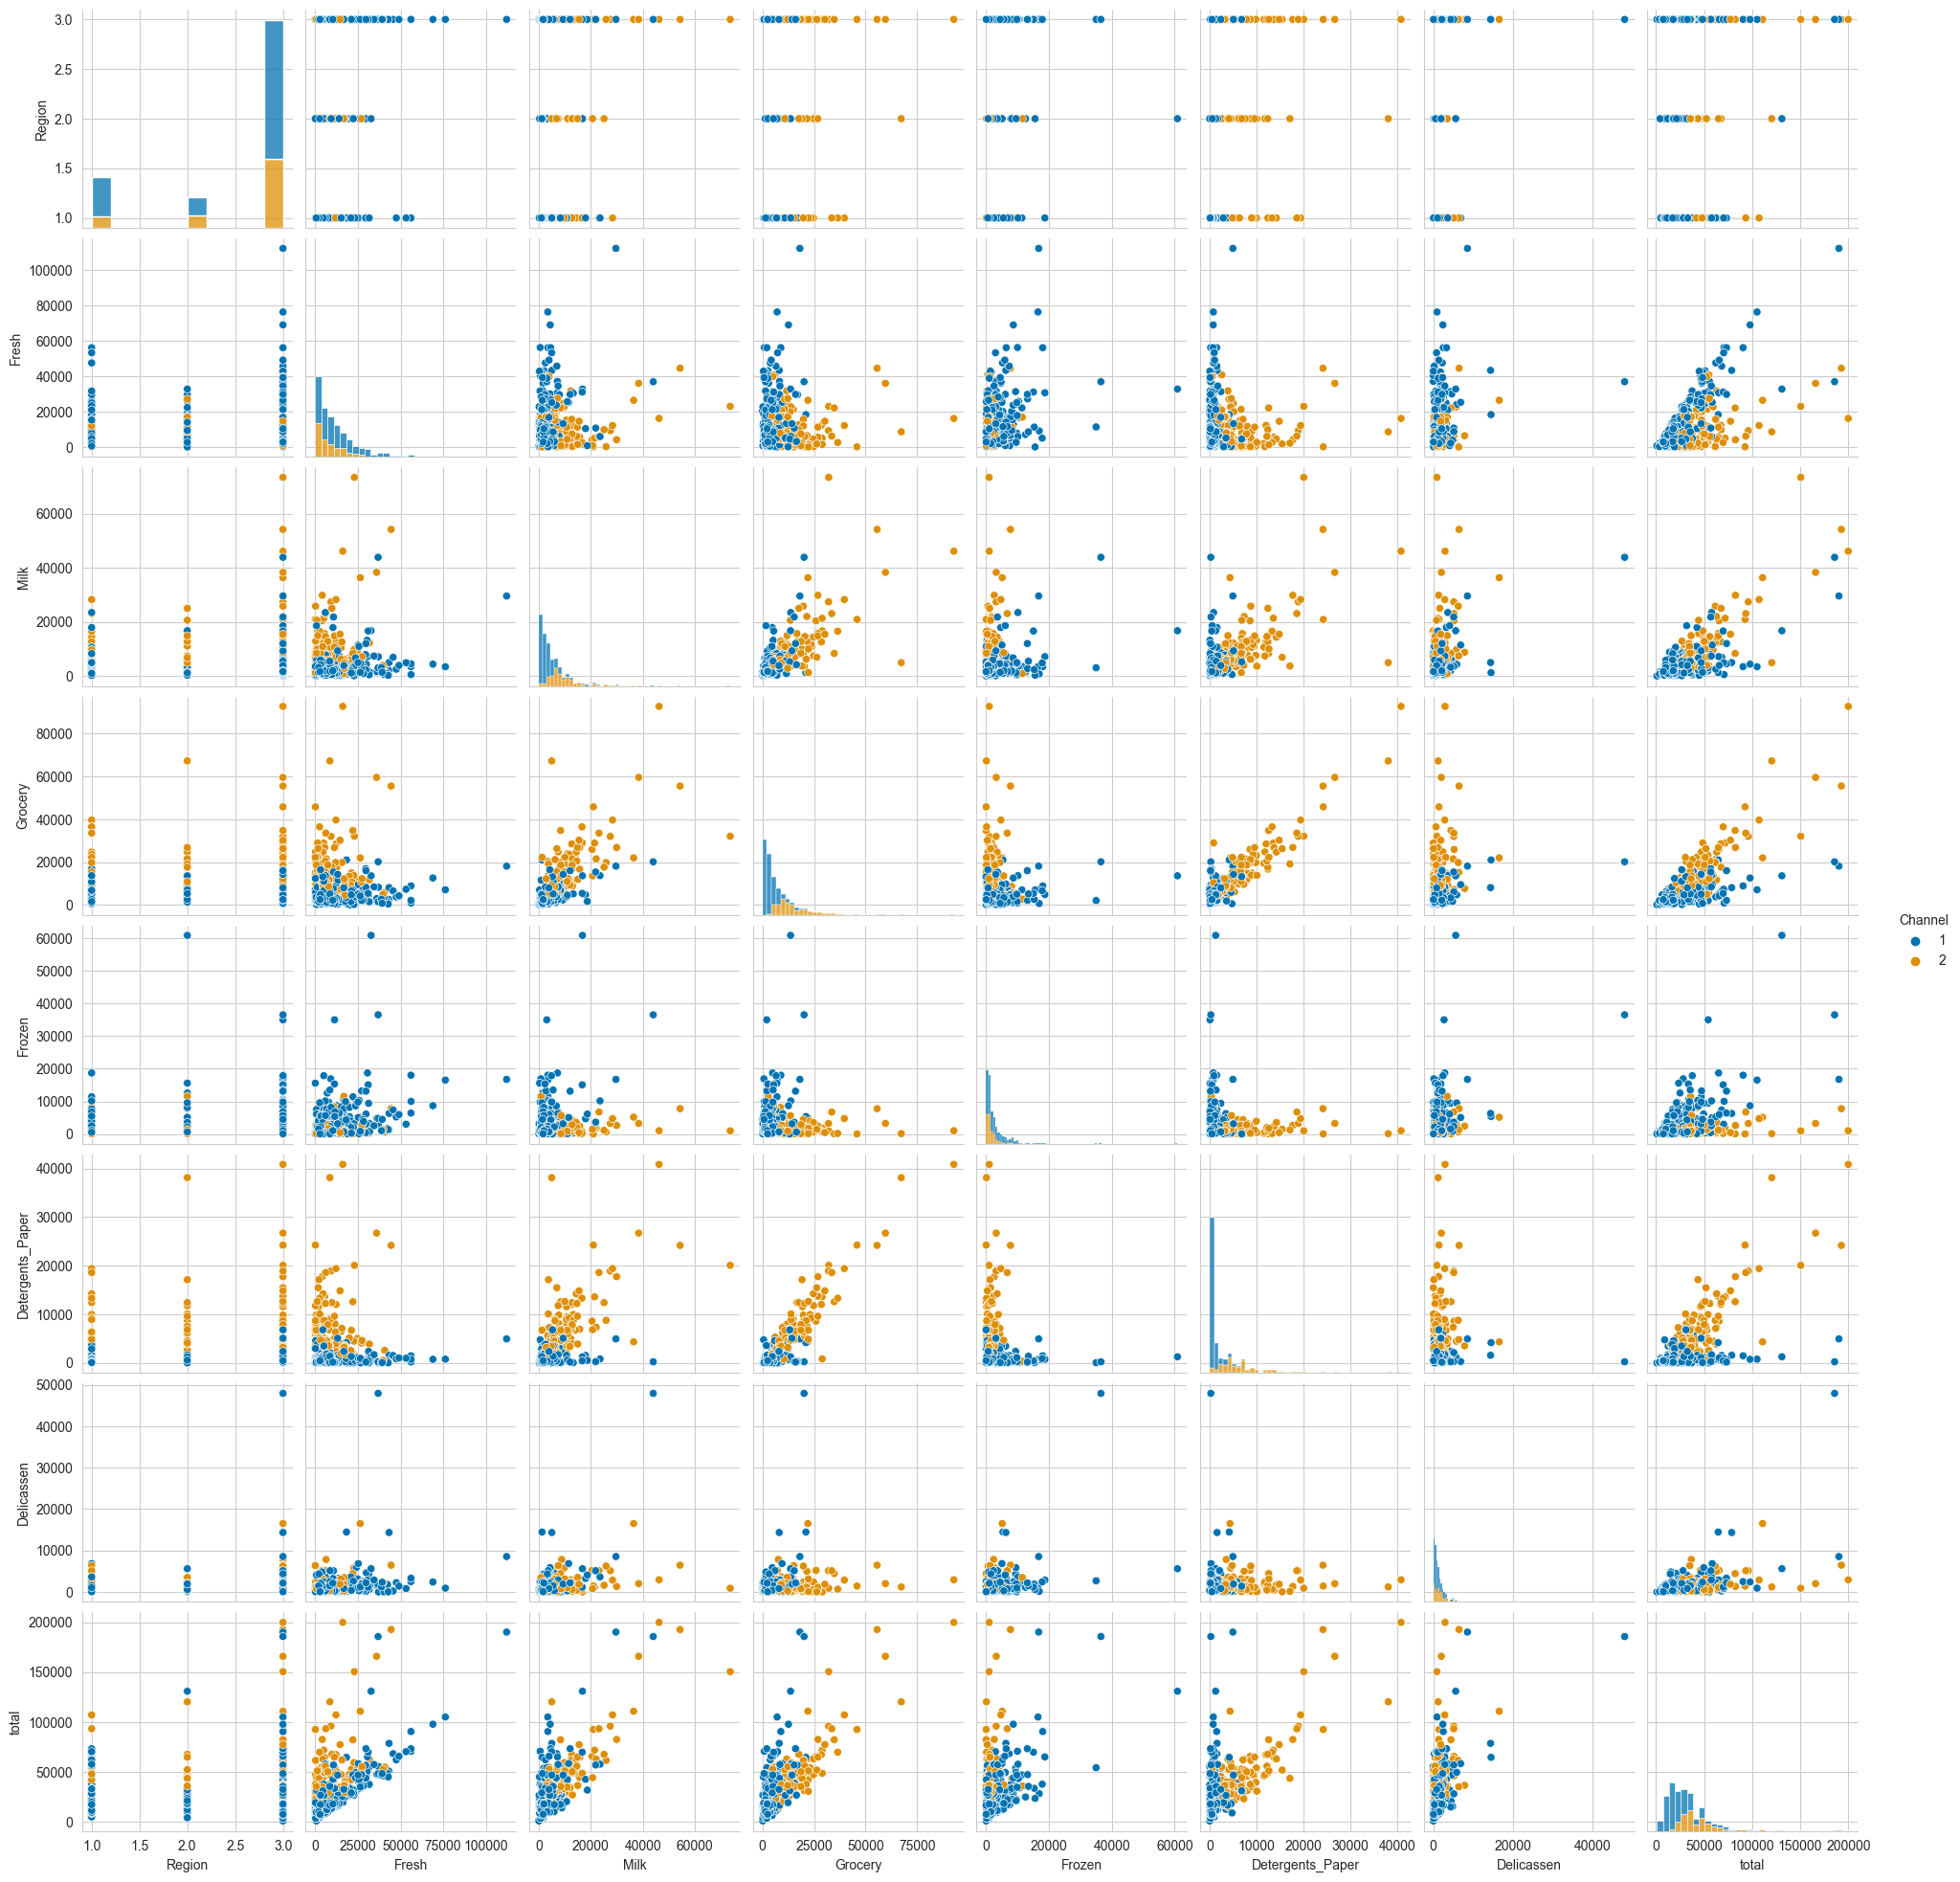

In [5]:
sns.pairplot(
    df,
    hue="Channel",
    palette=sns.color_palette("colorblind", 2),
    diag_kind="hist",
    diag_kws={"multiple": "stack"},
)

## Riduzione dimensionale

In questa sezione ci occupiamo di due dei più comuni algoritmi di riduzione dimensionale, PCA e t-SNE, per aiutarci a visualizzare il nostro dataset. Dato che lavoreremo utilizzando le distanze fra le osservazioni le standardizzeremo usando la classe `StandardScaler` di sklearn. Confronteremo le nostre clusterizzazioni con i valori di queste variabili categoriche, "Channel" e "Region".

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)
scaled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Channel,440.0,1.614870e-17,1.001138,-0.690297,-0.690297,-0.690297,1.448652,1.448652
Region,440.0,3.552714e-16,1.001138,-1.995342,-0.702337,0.590668,0.590668,0.590668
Fresh,440.0,-3.431598e-17,1.001138,-0.949683,-0.702334,-0.276760,0.390523,7.927738
Milk,440.0,0.000000e+00,1.001138,-0.778795,-0.578306,-0.294258,0.189092,9.183650
Grocery,440.0,-4.037175e-17,1.001138,-0.837334,-0.610836,-0.336668,0.284911,8.936528
Frozen,440.0,3.633457e-17,1.001138,-0.628343,-0.480431,-0.318804,0.099464,11.919002
Detergents_Paper,440.0,2.422305e-17,1.001138,-0.604416,-0.551135,-0.433600,0.218482,7.967672
Delicassen,440.0,-8.074349e-18,1.001138,-0.540264,-0.396401,-0.198577,0.104860,16.478447
total,440.0,1.291896e-16,1.001138,-1.227749,-0.599301,-0.217810,0.306969,6.330728


### PCA

L'algoritmo PCA (Principal Component Analyis) mira ad estrarre, attraverso una trasformazione lineare, le componenti principali del dataset, ordinandole per varianza attribuibile alla singola componente. Può essere utile sia come preprocessing dei dati (avendo però il difetto di ridurre la spiegabilità del modello ottenuto) o per ottenere una rappresentazione a bassa dimensione del dataset (considerando solo le prime 2-3 componenti).

/Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='X_0', ylabel='X_1'>

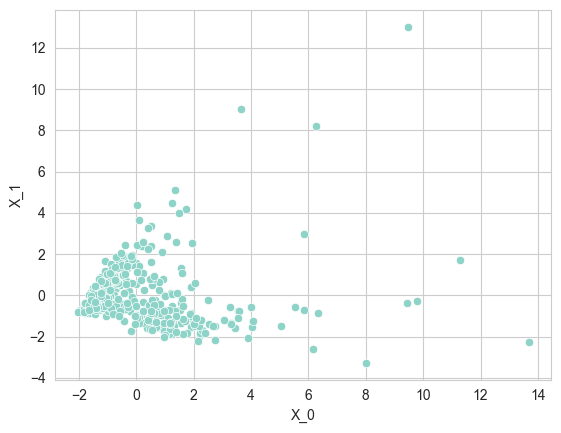

In [7]:
from sklearn.decomposition import PCA

n_components = 3
pca = PCA(n_components=n_components, copy=True)
pca_df = pd.DataFrame(
    pca.fit_transform(scaled_df), columns=[f"X_{i}" for i in range(n_components)]
)
sns.scatterplot(pca_df, x="X_0", y="X_1")

/Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/seaborn/_oldcore.

<Axes: xlabel='X_0', ylabel='X_1'>

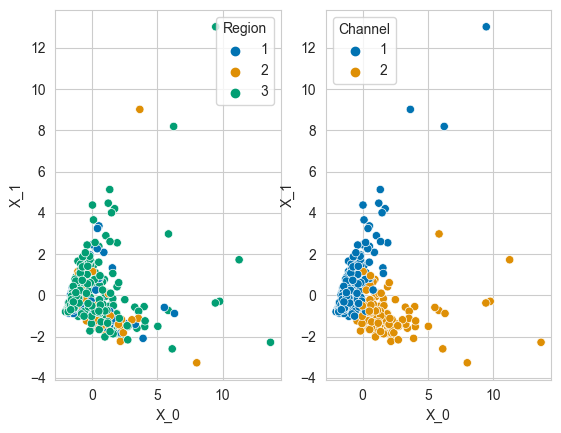

In [8]:
fig, axs = plt.subplots(1,2)
sns.scatterplot(pca_df, x="X_0", y="X_1", hue=df["Region"], palette="colorblind", ax=axs[0])
sns.scatterplot(pca_df, x="X_0", y="X_1", hue=df["Channel"], palette="colorblind", ax=axs[1])

Possiamo facilmente studiare la composizione delle componenti principali:

In [9]:
components_df = pd.DataFrame(
    pca.components_, columns=scaled_df.columns, index=["X_0", "X_1", "X_2"]
)
display(components_df)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,total
X_0,0.327616,0.024959,0.102304,0.448164,0.470479,0.076023,0.439179,0.219255,0.461137
X_1,-0.337254,0.023586,0.511969,0.021932,-0.180422,0.532761,-0.276621,0.391910,0.276786
X_2,-0.084271,-0.983458,-0.086915,0.021080,0.043703,0.115704,0.047087,-0.010983,0.008608


Possiamo inoltre visualizzare le prime 3 componenti del dataset trasformato in un widget 3D utilizzando la libreria `plotly`:

In [10]:
px.scatter_3d(pca_df,x="X_0",y="X_1",z="X_2", color=df["Channel"])

In [11]:
px.scatter_3d(pca_df,x="X_0",y="X_1",z="X_2", color=df["Region"])

### t-SNE

Il secondo algoritmo di riduzione dimensionale considerato è t-SNE (t-distributed Stochastic Neighbor Embedding): a differenza della PCA, t-SNE è nonlineare e mira a preservare le distanze relative fra osservazioni nell'embedding a dimensione bassa. Oltre alla dimensione dell'embedding, i parametri rilevanti dell'algoritmo sono:

- `perplexity`: rappresenta approssimativamente il numero di punti vicini da considerare per ottenere l'embedding di un punto. È consigliato un valore fra 5 e 50.
- `n_iter`: il numero di iterazioni dell'algoritmo. Preferibilmente maggiore di 250, dovrebbe essere sufficientemente alto da permettere all'algoritmo di raggiungere una configurazione stabile.
- `distance`: la definizione di distanza utilizzata dall'algoritmo.
- `random_state`: l'algoritmo dipende da valori casuali. È quindi necessario fissare questo valore per garantire la riproducibilità dei risultati.

La quantità che l'algoritmo cerca di minimizzare è la divergenza di Kullback-Lieber della distribuzione originale e di quella a dimensione bassa.

/Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

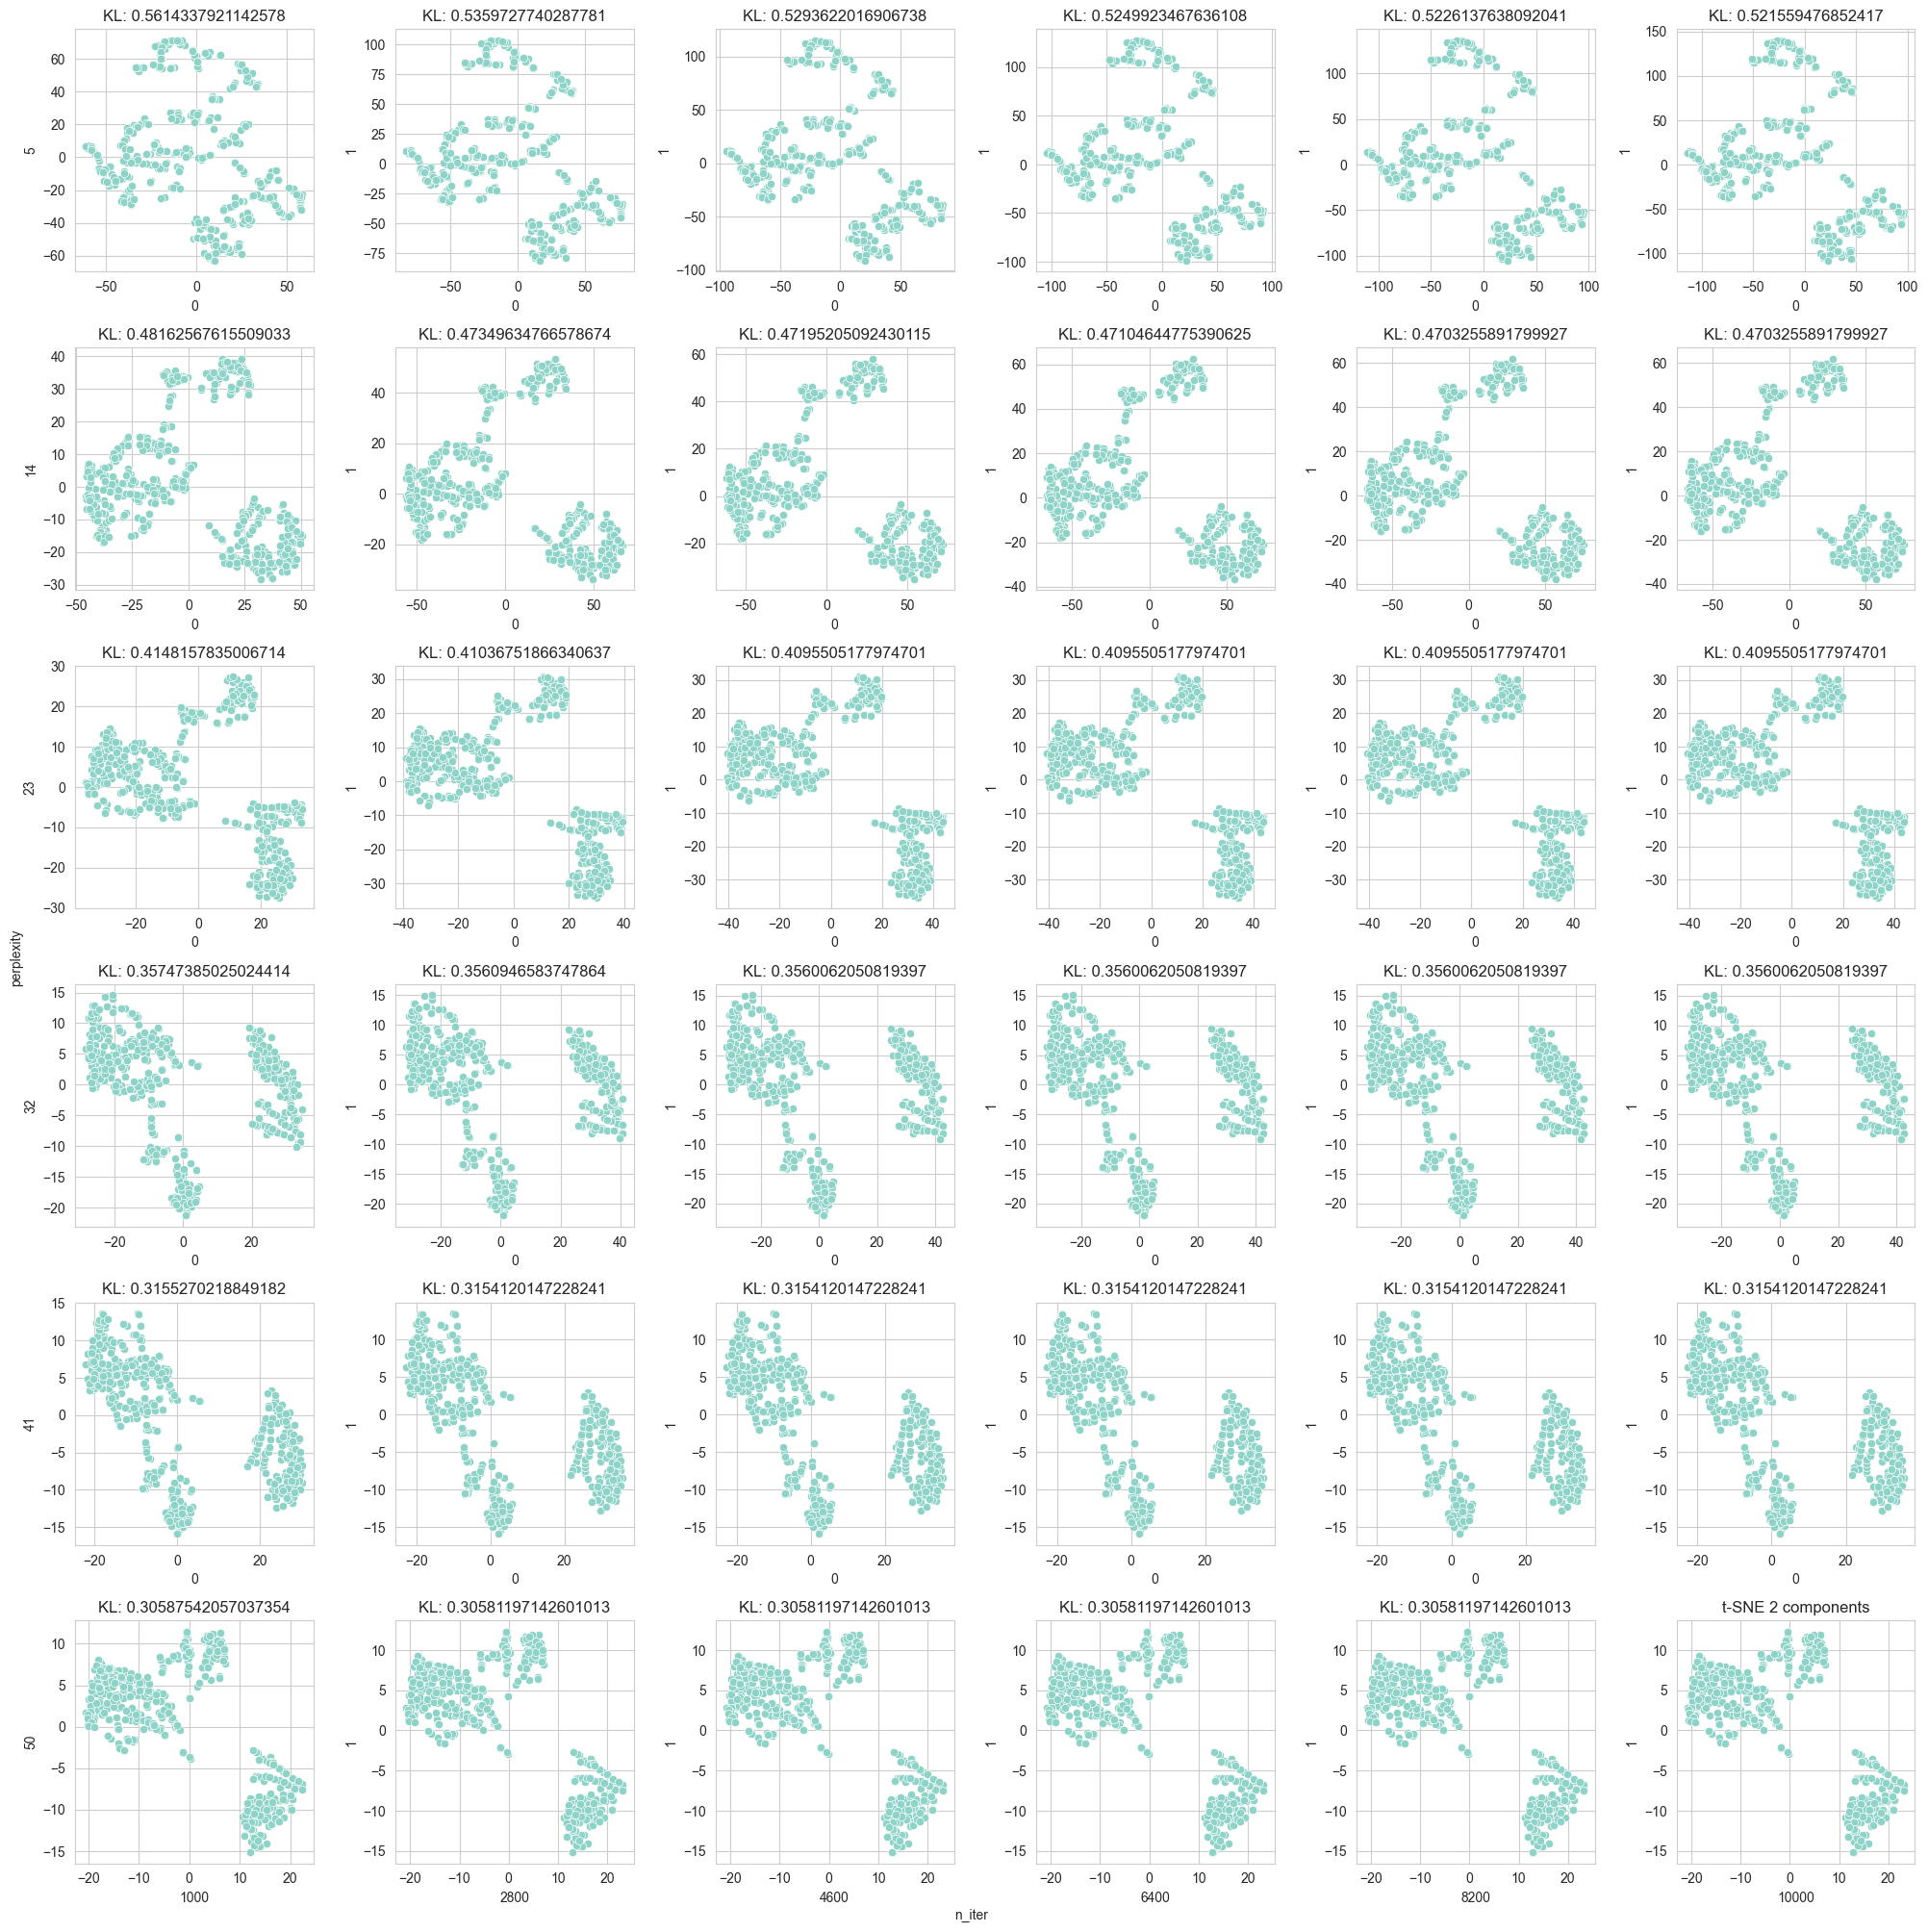

In [12]:
from sklearn.manifold import TSNE

tsne_space = {"perplexity": range(5, 51, 9), "n_iter": range(1000, 10001, 1800)}

fig, axs = plt.subplots(6, 6, figsize=(20, 20))
for i, perp in enumerate(tsne_space["perplexity"]):
    for j, n_it in enumerate(tsne_space["n_iter"]):
        tsne = TSNE(
            n_components=2, perplexity=perp, n_iter=n_it, n_jobs=-1, random_state=42
        )
        tsne_df = tsne.fit_transform(scaled_df)
        sns.scatterplot(pd.DataFrame(tsne_df), x=0, y=1, ax=axs[i, j])
        axs[i, j].set_title("KL: {kl}".format(kl=tsne.kl_divergence_))
        if i == len(tsne_space["perplexity"]) - 1:
            axs[i, j].set_xlabel(n_it)
        if j == 0:
            axs[i, j].set_ylabel(perp)
plt.title("t-SNE 2 components")
fig.text(0.5,0, "n_iter", ha="center")
fig.text(0, 0.5, "perplexity", va="center", rotation="vertical")
plt.tight_layout()

Come prima possiamo implementare un t-SNE a 3 componenti e visualizzarlo in 3D:

In [13]:
tsne = TSNE(
            n_components=3,
            perplexity=30,
            n_iter=10000,
            n_jobs=-1,
            random_state=42
        )

tsne_df = pd.DataFrame(tsne.fit_transform(scaled_df), columns=["X_0", "X_1", "X_2"])
px.scatter_3d(tsne_df,x="X_0",y="X_1",z="X_2")

## Clustering

I modelli di clustering sono algoritmi di apprendimento non supervisionato che cercano di partizionare le osservazioni di un dataset in classi, il cui numero può essere fissato o "appreso" dal dataset, di osservazioni simili fra di loro e distinte da quelle delle altri classi. Alcuni degli algoritmi più comunemente utilizzati sono gli algoritmi k-means e hierarchical. 

### K-means Clustering

Dato un numero intero positivo `k`, l'algoritmo di k-means clustering divide il dataset in k classi, cercando di minimizzare una distanza scelta fra le osservazioni dello stessa classe e massimizzare quella rispetto ai membri delle altre classi.

In genere il numero di classi `k`, se non noto per domain knowledge, viene scelto tramite il cosiddetto 'elbow method': l'algoritmo viene applicato con diversi valori di `k` e viene scelto il valore per cui la diminuzione della somma dei quadrati delle distanza dagli altri elementi del proprio cluster rallenta.

Procediamo quindi ad allenare diversi modelli `KMeans`:

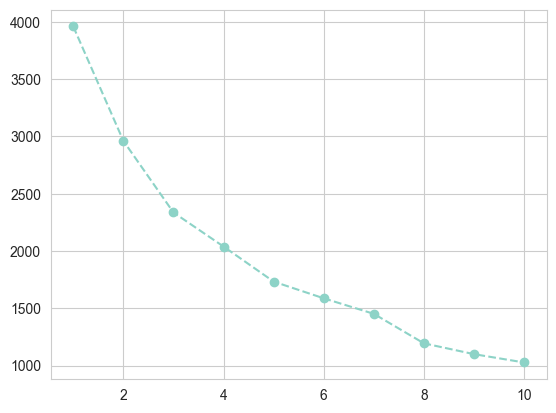

In [14]:
from sklearn.cluster import KMeans

ssd = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, max_iter=1000,n_init="auto", random_state=42)
    cluster_fl = kmeans.fit(scaled_df)
    ssd.append(kmeans.inertia_)

plt.plot(range(1,11), ssd, "o--")

Qua possiamo osservare il risultato del clustering sovrapposto a quello del t-SNE.

In [15]:
kmeans = KMeans(n_clusters=5, max_iter=1000,n_init="auto", random_state=42)
results = kmeans.fit_predict(scaled_df)
px.scatter_3d(tsne_df,x="X_0",y="X_1",z="X_2", color=results)

### DBSCAN

Ora applichiamo un altro algoritmo di clustering al nostro dataset: DBSCAN (Density-Based Spatial Clustering of Applications with Noise) è un algoritmo che partiziona le osservazioni in base la densità di esse nello spazio.
I parametri principali di DBSCAN sono due:

- `metric`: la definizione di distanza usata per costruire gli intorni,
- $\varepsilon$ (`eps`): il raggio dell'intorno assegnato ad ogni punto per la valutazione del cluster di appartenenza. Tale valore viene usualmente scelto con una variante dell'elbow method: prepariamo un grafico che rappresenti la distanza media dai `min_samples` valori più vicini per ciascun punto e cerchiamo un "gomito": quello sarà un buon valore per $\varepsilon$, separando i punti in cluster densi (quelli con distanza media bassa) dalle anomalie (a distanza media più alta).
- `min_samples`: numero minimo di punti presenti nell'intorno necessari per considerarlo parte di un cluster. In genere `min_samples`>`n_features`+1, spesso `min_samples`=2*`n_features` è un buon punto di partenza. Il valore scelto dipende dalla quantità di outlier nel dataset.

L'algoritmo classifica i punti come *core* o *anomaly*. Una visualizzazione del procedimento è disponibile [qui](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/).

Per prima cosa fissiamo `min_samples`=2*`n_features` e studiamo le `min_samples`-distanze.

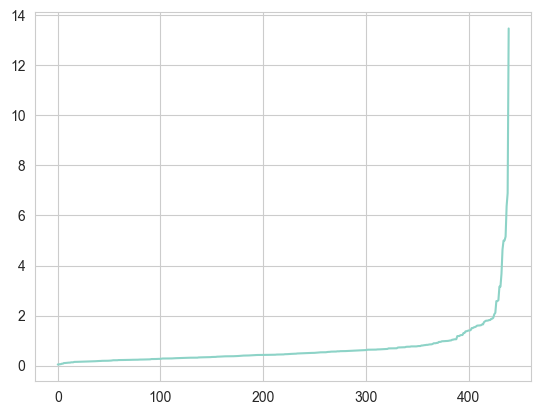

In [16]:
from sklearn.neighbors import NearestNeighbors

# Fissiamo min_samples
min_samples = 2*scaled_df.shape[1]

# Calcoliamo le k-distanze
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(scaled_df)
distances, indices = neighbors_fit.kneighbors(scaled_df)

# Ordiniamo le distanze in ordine crescente e mostriamo il grafico
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Per comodità sceglieremo $\varepsilon$=2. Volendo migliorare il nostro modello ripeteremmo il processo per valori leggermente diversi di `min_samples`. Alleniamo ora il modello DBSCAN.

In [17]:
from sklearn.cluster import DBSCAN

eps = 2

dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
dbscan_results = dbscan.fit_predict(scaled_df)
px.scatter_3d(tsne_df,x="X_0",y="X_1",z="X_2", color=dbscan_results)

Notiamo che DBSCAN identifica due cluster (`cluster`=0,1) e alcuni outlier (`cluster`=-1). Confrontiamolo con la feature `Channel` e quella `Region`:

In [18]:
px.scatter_3d(tsne_df,x="X_0",y="X_1",z="X_2", color=df["Channel"])

In [19]:
px.scatter_3d(tsne_df,x="X_0",y="X_1",z="X_2", color=df["Region"])